In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

from xgboost import XGBClassifier


# Necessary to get names out
SimpleImputer.get_feature_names_out = (lambda self, names=None:
                                       self.feature_names_in_)

In [2]:
features_num = [
    "Z_BEST", "z1_median", "u_f", "u_e", "u_e_raw", "Bw_f", "Bw_e", "Bw_e_raw", "R_f", "R_e", 
    "R_e_raw", "I_f", "I_e", "I_e_raw", "z_f", "z_e", "z_e_raw", "z_Subaru_f", "z_Subaru_e", 
    "z_Subaru_e_raw", "y_f", "y_e", "y_e_raw", "J_f", "J_e", "J_e_raw", "H_f", 
    "H_e", "H_e_raw", "K_f", "K_e", "K_e_raw", "Ks_f", "Ks_e", "Ks_e_raw", "ch1_f", "ch1_e", "ch1_e_raw", "ch2_f", 
    "ch2_e", "ch2_e_raw", "ch3_f", "ch3_e", "ch3_e_raw", "ch4_f", "ch4_e", "ch4_e_raw", "MIPS_24_f", 
    "MIPS_24_e", "MIPS_24_e_raw", "PACS_100_f", "PACS_100_e", "PACS_100_e_raw", "PACS_160_f", "PACS_160_e", 
    "PACS_160_e_raw", "SPIRE_250_f", "SPIRE_250_e", "SPIRE_250_e_raw", "SPIRE_350_f", "SPIRE_350_e", "SPIRE_350_e_raw", 
    "SPIRE_500_f", "SPIRE_500_e", "SPIRE_500_e_raw"

]
features_cat_binary = [
    "FLAG_OVERLAP", "XID+_rerun_mips", "XID+_rerun_pacs", "XID+_rerun_SPIRE", "CHANGE_FLAG_ID", 
    "CHANGE_FLAG_ZBEST", "CHANGE_FLAG_DEEP", "CHANGE_FLAG_FIR", "FLAG_GOOD"
]
features_cat_non_binary = [
    "FLAG_DEEP"
]
features_drop = [
    "Source_Name"
]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [3]:
# Creating the pipeline
transformer_num = make_pipeline(
    SimpleImputer(strategy="mean"),  # there are a few missing values
    StandardScaler(),
)
# Almost all cat features are already binary, so don't have to be one-hot encoded
transformer_cat_binary = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
)
transformer_cat_non_binary = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(sparse=False)
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat_binary, features_cat_binary),
    (transformer_cat_non_binary, features_cat_non_binary),
)

In [4]:
data = pd.read_csv("../../Data/Fangyou_data/Cleaned/Bootes_clean.csv")

In [5]:
# Dropping required columns
X = data.drop(columns=features_drop)
X = X.drop(columns=y_column)
y = data[y_column]

In [6]:
# Transforming y to labels
le = preprocessing.LabelEncoder()
labels = np.unique(y)
y = le.fit_transform(y)

# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [7]:
# Transforming the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [8]:
# Class weights
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# PCA

In [9]:
pca = PCA().fit(X_train)

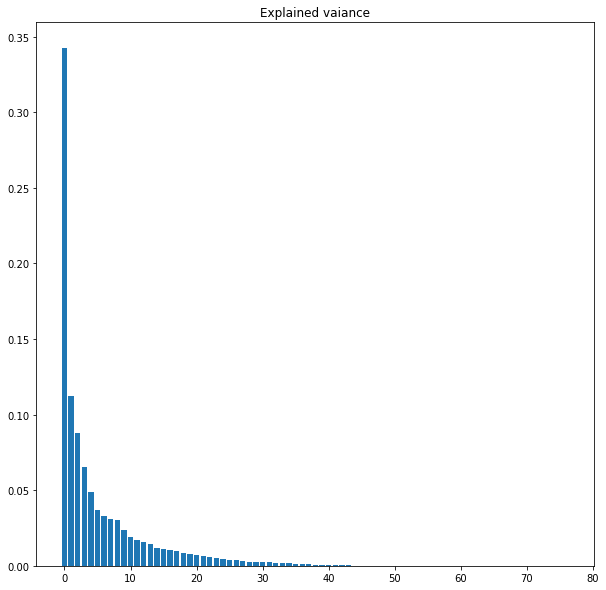

In [10]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10,10))
plt.bar(range(len(explained_variance)),explained_variance)
plt.title("Explained vaiance")
plt.show()

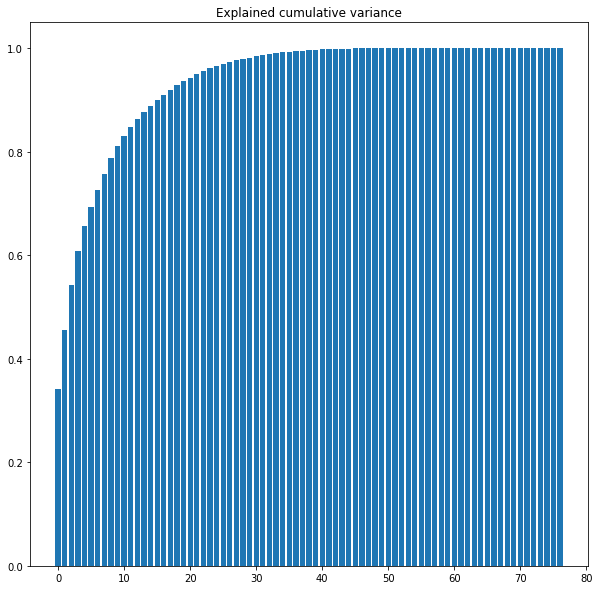

In [11]:
plt.figure(figsize=(10,10))
plt.bar(range(len(explained_variance)),explained_variance.cumsum())
plt.title("Explained cumulative variance")
plt.show()

# Random forest

In [12]:
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced")
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [13]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8549    0.5492    0.6687       976
quasar-like radio AGN / high-excitation radio galaxy     0.5000    0.0077    0.0152       130
                                     radio-quiet AGN     0.7466    0.4893    0.5912       560
                                 star-forming galaxy     0.8196    0.9699    0.8884      3653

                                            accuracy                         0.8186      5319
                                           macro avg     0.7303    0.5040    0.5409      5319
                                        weighted avg     0.8106    0.8186    0.7955      5319



[]

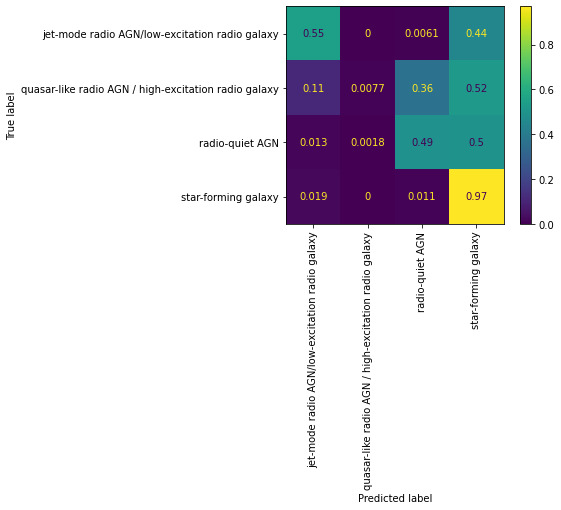

In [14]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [15]:
random_forest_feature_importance = pd.DataFrame(
    np.array([preprocessor.get_feature_names_out(), clf.feature_importances_]).T,
                                               columns=['Feature', 'Importance'])
random_forest_feature_importance = random_forest_feature_importance.sort_values(by=['Importance'], ascending=False)

[]

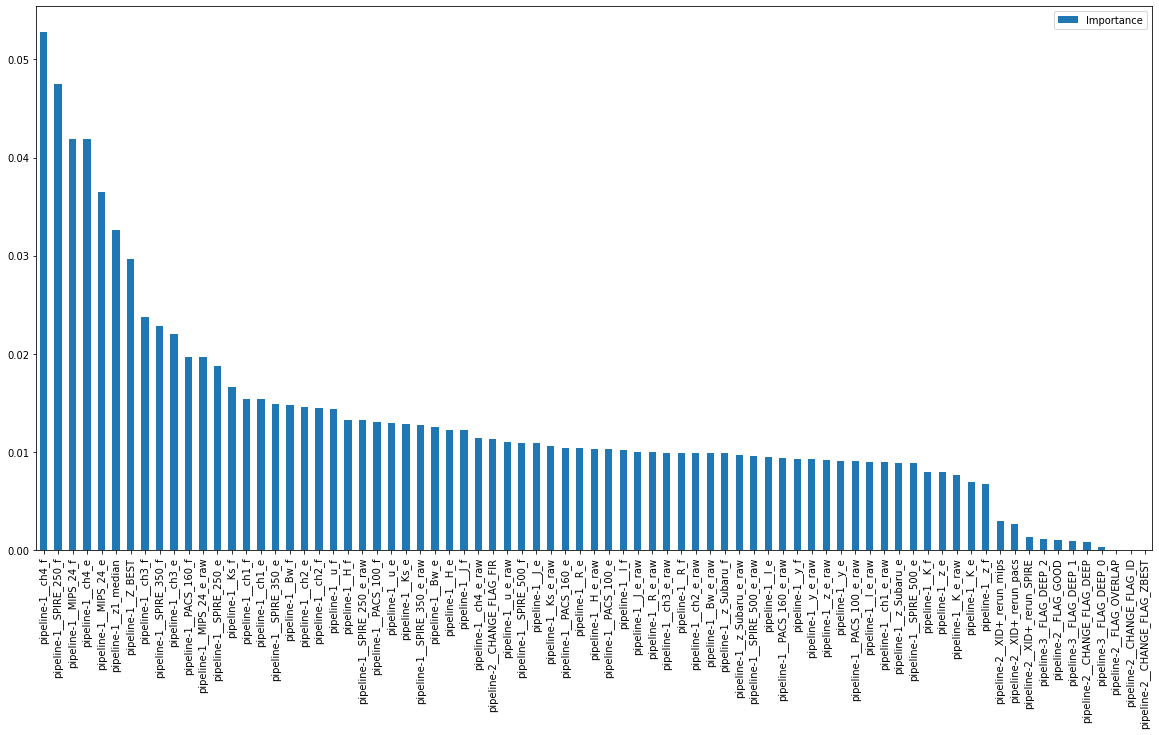

In [16]:
ax = random_forest_feature_importance.plot(kind='bar', figsize=(20,10))
ax.set_xticklabels(random_forest_feature_importance.Feature)
plt.plot()

## Hyperparameter tuning

In [17]:
# Metrics for hyperparameter tuning
metrics = {"Accuracy": "accuracy",
          "Balanced accuracy": "balanced_accuracy",
          "F1 score": "f1_weighted"}

In [18]:
# Parameter space
parameters = {"n_estimators": [10,20,50,100,150,200],
             "criterion": ["gini", "entropy"],
             "max_depth": [10,30,50,70],
             "min_samples_split": [2,10,20],
             }

In [19]:
random_forest = RandomForestClassifier()
clf = GridSearchCV(estimator=random_forest, 
                   param_grid=parameters,
                  scoring=metrics,
                  refit="Accuracy",
                  return_train_score=True,
                  n_jobs=-1,
                  cv=2,
                  verbose=4)

clf.fit(X_train, y_train)

Fitting 2 folds for each of 144 candidates, totalling 288 fits



KeyboardInterrupt



In [ ]:
clf

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

# XGboost

In [20]:
model = XGBClassifier(use_label_encoder=False, max_depth=7)
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.05892
[1]	validation_0-mlogloss:0.87570
[2]	validation_0-mlogloss:0.75996
[3]	validation_0-mlogloss:0.68113
[4]	validation_0-mlogloss:0.62528
[5]	validation_0-mlogloss:0.58577
[6]	validation_0-mlogloss:0.55597
[7]	validation_0-mlogloss:0.53500
[8]	validation_0-mlogloss:0.52003
[9]	validation_0-mlogloss:0.50874
[10]	validation_0-mlogloss:0.49968
[11]	validation_0-mlogloss:0.49198
[12]	validation_0-mlogloss:0.48738
[13]	validation_0-mlogloss:0.48214
[14]	validation_0-mlogloss:0.47913
[15]	validation_0-mlogloss:0.47700
[16]	validation_0-mlogloss:0.47543
[17]	validation_0-mlogloss:0.47406
[18]	validation_0-mlogloss:0.47382
[19]	validation_0-mlogloss:0.47261
[20]	validation_0-mlogloss:0.47278
[21]	validation_0-mlogloss:0.47107
[22]	validation_0-mlogloss:0.47133
[23]	validation_0-mlogloss:0.47108
[24]	validation_0-mlogloss:0.47118
[25]	validation_0-mlogloss:0.47194
[26]	validation_0-mlogloss:0.47330
[27]	validation_0-mlogloss:0.47348
[28]	validation_0-mlogloss:0.4

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [21]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8223    0.6352    0.7168       976
quasar-like radio AGN / high-excitation radio galaxy     0.4545    0.0385    0.0709       130
                                     radio-quiet AGN     0.6934    0.6018    0.6444       560
                                 star-forming galaxy     0.8530    0.9499    0.8988      3653

                                            accuracy                         0.8332      5319
                                           macro avg     0.7058    0.5563    0.5827      5319
                                        weighted avg     0.8208    0.8332    0.8184      5319



[]

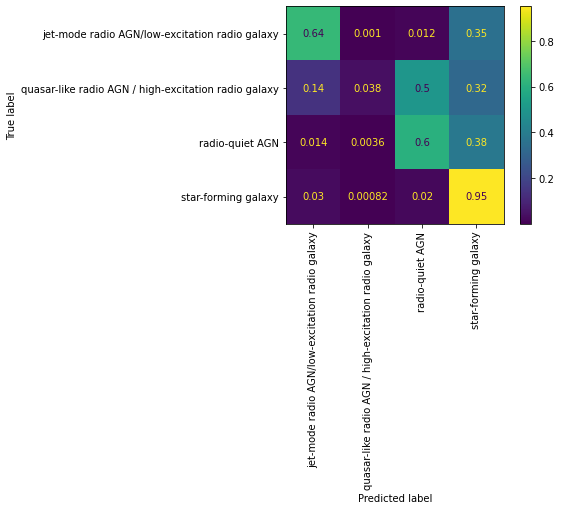

In [22]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# SVM

In [23]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [24]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8531    0.4580    0.5960       976
quasar-like radio AGN / high-excitation radio galaxy     0.0000    0.0000    0.0000       130
                                     radio-quiet AGN     0.7748    0.3071    0.4399       560
                                 star-forming galaxy     0.7837    0.9811    0.8714      3653

                                            accuracy                         0.7902      5319
                                           macro avg     0.6029    0.4366    0.4768      5319
                                        weighted avg     0.7764    0.7902    0.7541      5319



C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: Unde

[]

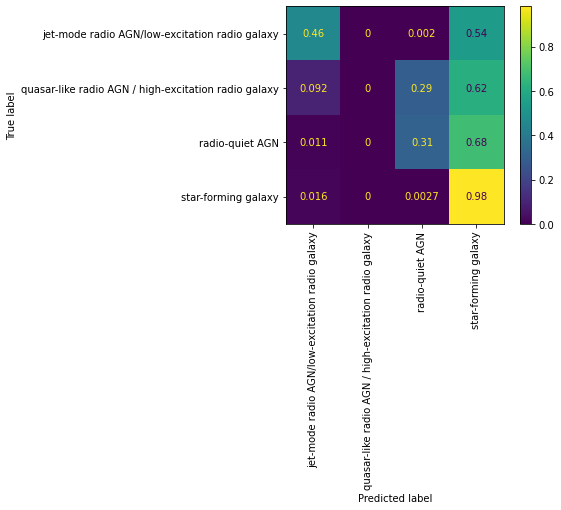

In [25]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()